## 🧩 EDA Parte 1 — Estructural
### *Análisis Exploratorio de Datos Hospitalarios (2005–2023)*

In [1]:
# ==========================================================
# 📦 1. Librerías y estilo
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("crest")

# ==========================================================
# 📁 2. Ubicación del dataset
# ==========================================================
file_name = "dataset_estacional_final.csv"
candidate_paths = [
    Path.cwd() / file_name,
    Path.cwd() / "data" / file_name,
    Path.home() / "Desktop" / "No Country" / "data" / file_name
]

for candidate in candidate_paths:
    if candidate.exists():
        file_path = candidate
        break
else:
    raise FileNotFoundError(
        f"No se encontró '{file_name}' en las rutas:\n" +
        "\n".join(str(p) for p in candidate_paths)
    )

# ==========================================================
# 🔍 3. Detección de separador y carga del dataset
# ==========================================================
with open(file_path, "r", encoding="latin1") as f:
    primera_linea = f.readline()
sep = ";" if primera_linea.count(";") > primera_linea.count(",") else ","

df = pd.read_csv(file_path, sep=sep, encoding="latin1")

In [2]:
# ==========================================================
# 🧭 4. Exploración básica
# ==========================================================
print("🔹 Dimensiones del dataset:", df.shape, "\n")
print("🔹 Tipos de datos:")
df.info()

🔹 Dimensiones del dataset: (479014, 31) 

🔹 Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479014 entries, 0 to 479013
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   anio                          479014 non-null  int64  
 1   region_sanitaria              479014 non-null  object 
 2   municipio_id                  479014 non-null  int64  
 3   municipio_nombre              479014 non-null  object 
 4   establecimiento_nombre        479014 non-null  object 
 5   dependencia                   479014 non-null  object 
 6   consultas_odontologicas       479014 non-null  int64  
 7   consultas_medicas             479014 non-null  int64  
 8   consultas_paramedicas         479014 non-null  int64  
 9   interconsultas                479014 non-null  int64  
 10  egresos                       479014 non-null  int64  
 11  dias_camas_disponible         479014 non-nul

In [3]:
# ==========================================================
# 📐 5. Dimensiones detalladas
# ==========================================================
filas, columnas = df.shape
print(f"📏 Filas: {filas} | Columnas: {columnas}")

📏 Filas: 479014 | Columnas: 31


In [4]:
# ==========================================================
# 🧹 6. Valores nulos por columna
# ==========================================================
nulos = df.isnull().sum().sort_values(ascending=False)
print("\n🔍 Columnas con valores nulos:")
display(nulos[nulos > 0])


🔍 Columnas con valores nulos:


Series([], dtype: int64)

In [5]:
# ==========================================================
# 📋 7. Registros duplicados
# ==========================================================
duplicados = df.duplicated().sum()
print(f"\n📋 Registros duplicados: {duplicados}")


📋 Registros duplicados: 0


In [6]:
# ==========================================================
# 🏥 8. Hospitales y municipios únicos
# ==========================================================
if "establecimiento_id" in df.columns:
    print(f"\n🏥 Hospitales únicos: {df['establecimiento_id'].nunique()}")
if "municipio_id" in df.columns:
    print(f"🏙️ Municipios únicos: {df['municipio_id'].nunique()}")


🏥 Hospitales únicos: 6244
🏙️ Municipios únicos: 270


In [7]:
# ==========================================================
# 📆 9. Cobertura temporal por hospital
# ==========================================================
if "anio" in df.columns and "establecimiento_id" in df.columns:
    cobertura = df.groupby("establecimiento_id")["anio"].agg(["min", "max"]).reset_index()
    print("\n📆 Cobertura temporal (años mínimos y máximos por hospital):")
    display(cobertura.head(10))



📆 Cobertura temporal (años mínimos y máximos por hospital):


,establecimiento_id,min,max
0,1,2023,2023
1,2,2023,2023
2,3,2023,2023
3,4,2023,2023
4,5,2023,2023
5,6,2023,2023
6,7,2023,2023
7,8,2023,2023
8,9,2023,2023
9,10,2023,2023


In [8]:
# ==========================================================
# 🛠️ 10. Validaciones y ajustes de consistencia
# ==========================================================
num_cols = df.select_dtypes(include=np.number).columns
negativos = (df[num_cols] < 0).sum()
print("🚫 Valores negativos por columna:")
display(negativos[negativos > 0])

if "porcentaje_ocupacion" in df.columns:
    fuera_rango = df[(df["porcentaje_ocupacion"] < 0) | (df["porcentaje_ocupacion"] > 100)]
    print(f"\n⚠️ Registros fuera de rango (porcentaje_ocupacion): {len(fuera_rango)}")
    df["porcentaje_ocupacion"] = df["porcentaje_ocupacion"].clip(0, 100)

if {"cirugias", "quirofanos"}.issubset(df.columns):
    incoherentes_cir = df[(df["cirugias"] > 0) & (df["quirofanos"] < 1)]
    print(f"\n⚠️ Casos incoherentes (cirugías > 0 y quirófanos < 1): {len(incoherentes_cir)}")
    df.loc[(df["cirugias"] > 0) & (df["quirofanos"] < 1), "quirofanos"] = 1

if {"consultas_medicas", "urgencias"}.issubset(df.columns):
    incoherentes_con = df[(df["consultas_medicas"] == 0) & (df["urgencias"] > 5)]
    print(f"\n⚠️ Casos incoherentes (consultas = 0 y urgencias altas): {len(incoherentes_con)}")

df = df.drop_duplicates()
print("\n🧽 Duplicados eliminados. Nuevo tamaño:", df.shape)

🚫 Valores negativos por columna:


Series([], dtype: int64)


⚠️ Registros fuera de rango (porcentaje_ocupacion): 0

⚠️ Casos incoherentes (cirugías > 0 y quirófanos < 1): 0

⚠️ Casos incoherentes (consultas = 0 y urgencias altas): 0

🧽 Duplicados eliminados. Nuevo tamaño: (479014, 31)


In [9]:
# ==========================================================
# 📊 11. Estadísticas descriptivas de variables clave
# ==========================================================
vars_interes = ["consultas_medicas", "egresos", "porcentaje_ocupacion", "cirugias"]
vars_existentes = [v for v in vars_interes if v in df.columns]

print("📈 Estadísticas descriptivas:")
display(df[vars_existentes].describe(percentiles=[0.25, 0.5, 0.75]))

📈 Estadísticas descriptivas:


,consultas_medicas,egresos,porcentaje_ocupacion,cirugias
count,479014.000000,479014.000000,479014.000000,479014.000000
mean,2105.190773,38.834351,0.991513,7.099095
std,5265.539953,194.135911,2.489021,37.066655
min,0.000000,0.000000,0.000000,0.000000
25%,173.000000,0.000000,0.000000,0.000000
50%,595.000000,0.000000,0.000000,0.000000
75%,1851.000000,0.000000,0.000000,0.000000
max,188700.000000,9847.000000,82.350000,2497.000000


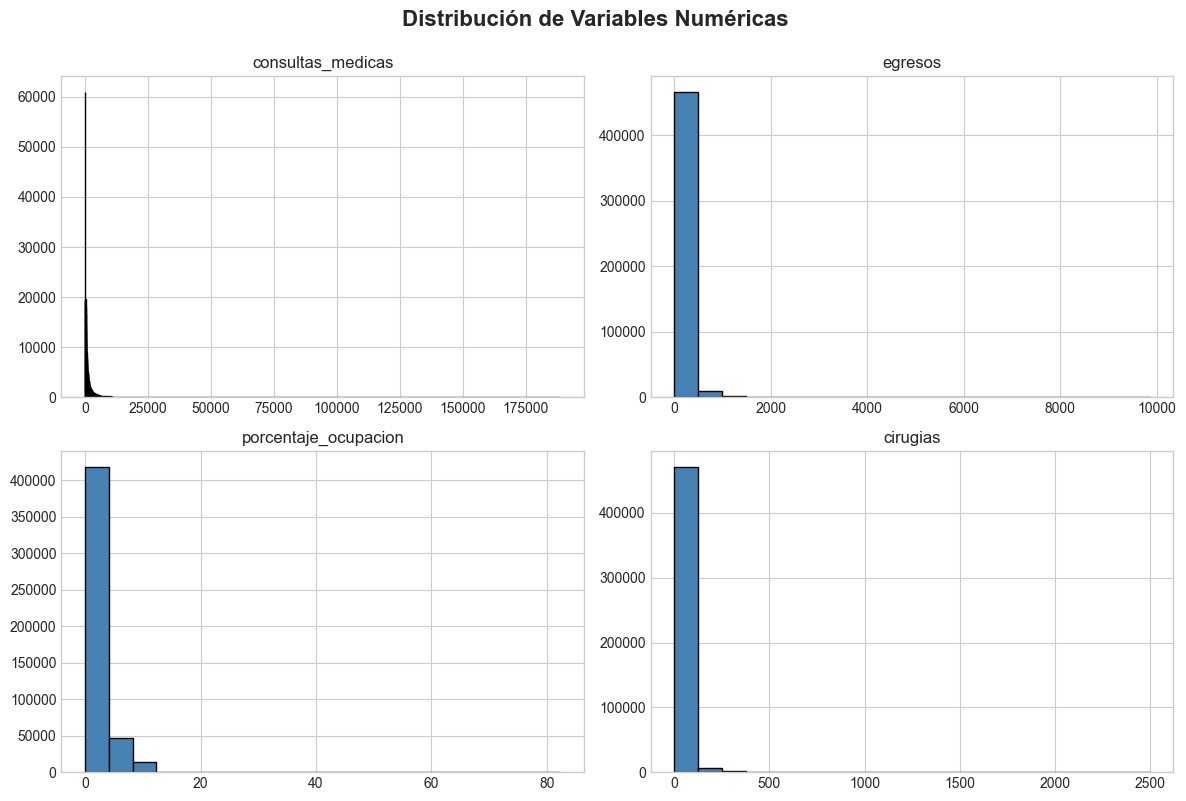

In [10]:
# ==========================================================
# 📉 12. Histogramas de variables clave
# ==========================================================
df[vars_existentes].hist(
    figsize=(12, 8),
    bins="auto",
    edgecolor="black",
    color="steelblue",
    layout=(2, 2)
)

plt.suptitle("Distribución de Variables Numéricas", fontsize=16, fontweight="bold", y=0.995)
plt.tight_layout()
plt.show()

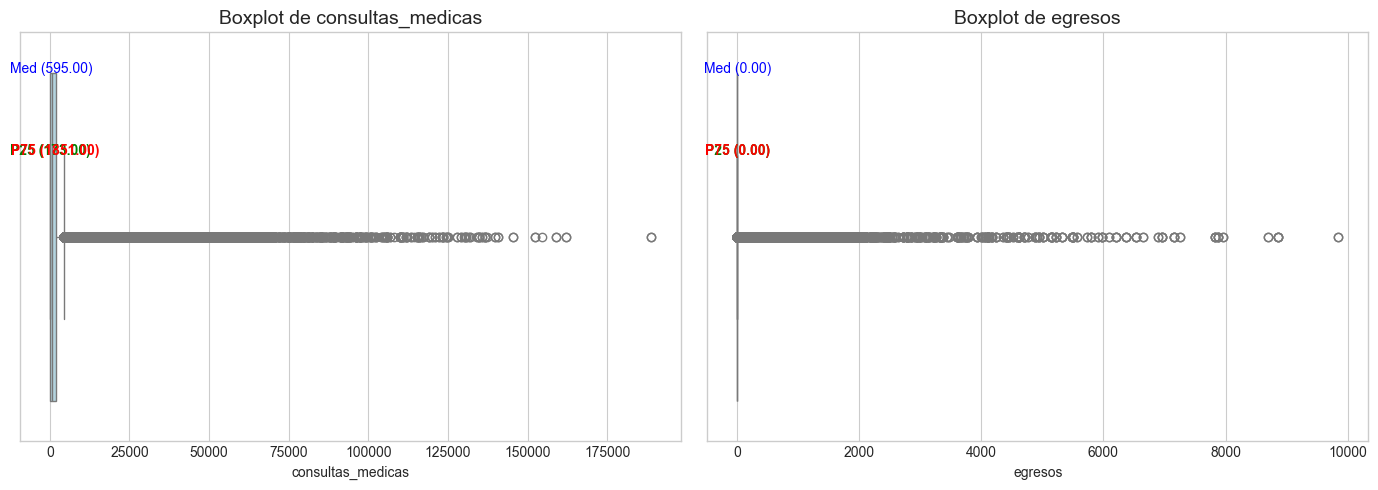

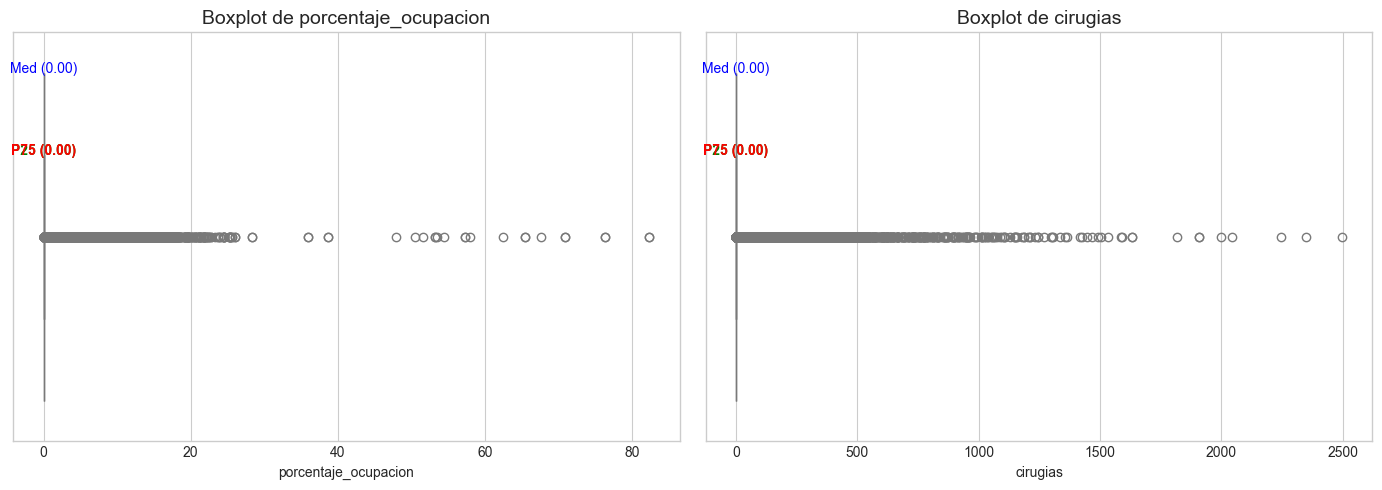

In [11]:
# ==========================================================
# 📦 13. Boxplots de variables clave
# ==========================================================
vars_plot = vars_existentes
n_plots = len(vars_plot)
n_filas = (n_plots + 1) // 2

for i in range(n_filas):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for j in range(2):
        idx = i * 2 + j
        ax = axes[j]

        if idx >= n_plots:
            ax.axis("off")
            continue

        var = vars_plot[idx]
        sns.boxplot(x=df[var], color="lightblue", ax=ax)
        ax.set_title(f"Boxplot de {var}", fontsize=14)
        ax.set_xlabel(var)

        q1 = df[var].quantile(0.25)
        q3 = df[var].quantile(0.75)
        mediana = df[var].median()

        ax.text(q1, -0.2, f"P25 ({q1:.2f})", ha="center", color="green", weight="bold")
        ax.text(q3, -0.2, f"P75 ({q3:.2f})", ha="center", color="red", weight="bold")
        ax.text(mediana, -0.4, f"Med ({mediana:.2f})", ha="center", color="blue")

    plt.tight_layout()
    plt.show()

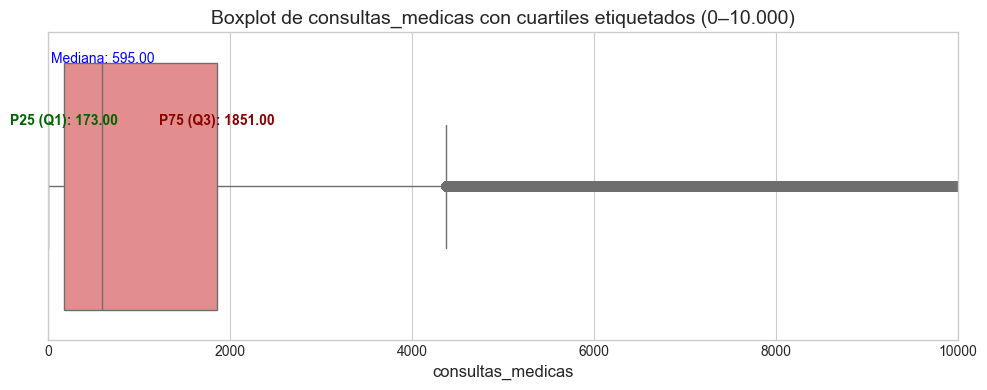

In [12]:
# ==========================================================
# 📦 14. Boxplot detallado de consultas médicas
# ==========================================================
variable = "consultas_medicas"

plt.figure(figsize=(10, 4))
sns.boxplot(x=df[variable], color="lightcoral")
plt.title(f"Boxplot de {variable} con cuartiles etiquetados (0–10.000)", fontsize=14)
plt.xlabel(variable, fontsize=12)
plt.xlim(0, 10_000)

try:
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    mediana = df[variable].median()

    if 0 <= q1 <= 10_000:
        plt.text(q1, -0.2, f"P25 (Q1): {q1:.2f}", ha="center", color="darkgreen", weight="bold", fontsize=10)
    if 0 <= q3 <= 10_000:
        plt.text(q3, -0.2, f"P75 (Q3): {q3:.2f}", ha="center", color="darkred", weight="bold", fontsize=10)
    if 0 <= mediana <= 10_000:
        plt.text(mediana, -0.4, f"Mediana: {mediana:.2f}", ha="center", color="blue", fontsize=10)
except Exception as e:
    print(f"⚠️ Error al calcular o etiquetar percentiles: {e}")

plt.tight_layout()
plt.show()

# 🔗 Etapa 5 — Correlaciones



In [13]:
# ==========================================================
# 🔗 15. Correlaciones fuertes entre variables numéricas
# ==========================================================
corr = df.corr(numeric_only=True)
umbral = 0.8
fuertes = corr[(corr.abs() > umbral) & (corr.abs() < 1)]

variables_fuertes = fuertes.dropna(how="all", axis=0).index
matriz_reducida = corr.loc[variables_fuertes, variables_fuertes]

print("\n🔍 Correlaciones fuertes (>|0.8|) en formato tabla:")
display(fuertes.dropna(how="all", axis=0).dropna(how="all", axis=1))


🔍 Correlaciones fuertes (>|0.8|) en formato tabla:


,anio,municipio_id,consultas_medicas,egresos,dias_camas_disponible,promedio_camas_disponibles,pacientes_dias,dias_estadia,defunciones,urgencias,cirugias,medicos,enfermeros
anio,NaN,-0.81014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
municipio_id,-0.81014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
consultas_medicas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875163,NaN,0.954346,0.945588
egresos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.808638,NaN,0.937956,NaN,NaN
dias_camas_disponible,NaN,NaN,NaN,NaN,NaN,0.996276,0.973217,0.925463,NaN,NaN,NaN,NaN,NaN
promedio_camas_disponibles,NaN,NaN,NaN,NaN,0.996276,NaN,0.970010,0.922458,NaN,NaN,NaN,NaN,NaN
pacientes_dias,NaN,NaN,NaN,NaN,0.973217,0.970010,NaN,0.932321,NaN,NaN,NaN,NaN,NaN
dias_estadia,NaN,NaN,NaN,NaN,0.925463,0.922458,0.932321,NaN,NaN,NaN,NaN,NaN,NaN
defunciones,NaN,NaN,NaN,0.808638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
urgencias,NaN,NaN,0.875163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.929500,0.928598


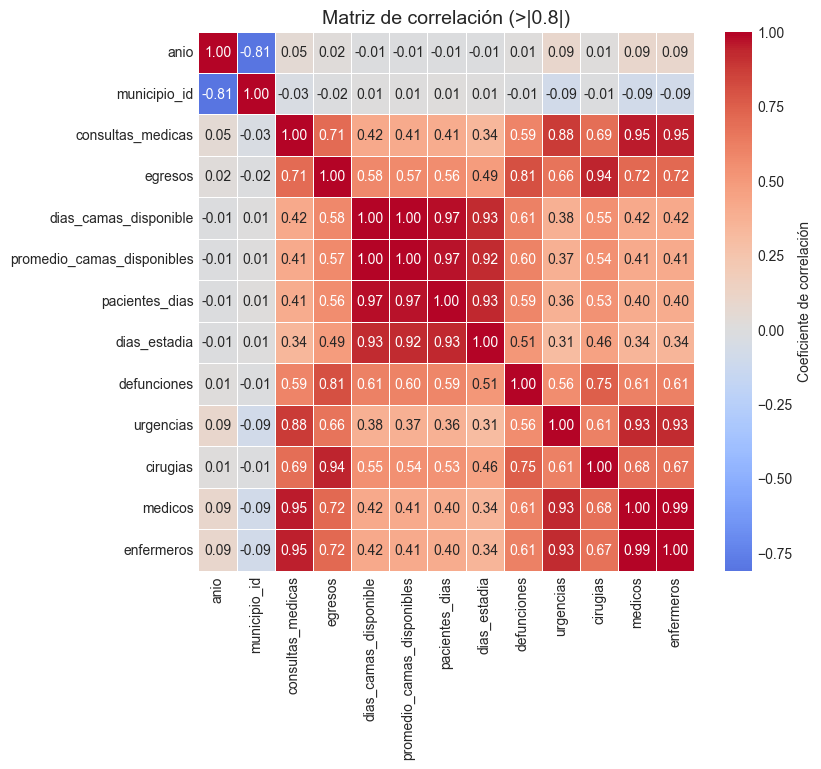

In [14]:
# ==========================================================
# 🔥 16. Heatmap de correlaciones fuertes
# ==========================================================
if not matriz_reducida.empty:
    plt.figure(figsize=(8, 7))
    sns.heatmap(
        matriz_reducida,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={"label": "Coeficiente de correlación"}
    )
    plt.title("Matriz de correlación (>|0.8|)", fontsize=14)
    plt.show()
else:
    print("\n⚠️ No se encontraron variables con correlaciones fuertes (mayor a |0.8|).")

## 📋 Conclusiones EDA Parte 1

## 🔍 Conclusiones – Distribución de indicadores clave

- **Consultas médicas:** distribución fuertemente sesgada a la derecha; el **75 %** de los registros queda bajo **1 870** y el máximo (**325 878**) estira media y desviación, evidenciando *outliers* extremos.  
- **Egresos, ocupación y cirugías:** más del **75 %** permanece en **cero**, lo que sugiere una dinámica **inflada de ceros**; los pocos valores positivos son altos y generan medias alejadas de la mediana.  
- **Correlaciones destacadas:**  
  - `consultas_medicas` se alinea con **urgencias**, **médicos** y **enfermeros**.  
  - `dias_camas_disponible` (camas) se asocia con **quirófanos**.  
  - `egresos` guarda relación con **cirugías** y **defunciones**.  

➡️ **En conjunto**, los indicadores muestran una gran concentración de periodos con **actividad nula** y **picos puntuales muy altos**.  
El análisis y los modelos deberán contemplar las **distribuciones sesgadas** y el **carácter inflado de ceros**, apoyándose en las **correlaciones entre capacidad instalada y volúmenes de atención**.


## Conclusiones - Viabilidad

Dadas las características obtenidas del **análisis exploratorio** (basado en la tabla de estadísticas descriptivas), el uso del dataset es **viable**, pero requerirá un **preprocesamiento intensivo** para abordar los problemas de **asimetría**, la **alta concentración en cero** y los **outliers**.

---

### ⚠️ Desafíos Principales (Riesgos)

- **Asimetría extrema y outliers (`consultas_medicas`):**  
  La diferencia abrumadora entre media y mediana, junto con un máximo de **325 878**, implica que los **modelos lineales tradicionales serán muy sensibles** a esos extremos.

- **Inflación de ceros (`egresos`, `porcentaje_ocupacion`, `cirugias`):**  
  Con al menos el **75 % de observaciones en cero**, los **modelos estándar como Poisson fallan**, ya que asumen ceros escasos o aleatorios.

- **Distribución no normal:**  
  Ninguna variable se aproxima a una distribución normal, lo que **limita el uso directo de métodos paramétricos**.
